# Biological Oceanography (BO)

<img src="Prochlorococcus_marinus.jpeg"/>


This tutorial is part of our Biological Oceanography day. It demonstrates how to do basic analysis and visualization of gridded biological data. We will use A,B,and C data which can be downloaded using CMAP API, a giant data database for Earth system observations and modeling. To download the data using API, please register at CMAP and generate your API key.

### Estimated tutorial time: 1.5 hours

## Tutorial goals

- Python Skills
    - Work with dataframes
    - Make different statistical plots
    - Data co-location
- BO knowledge
    - Learn about global ocean photosynthesis and primary productivity signatures from satellite observations 
    - Understand the vertical distributions of chlorophyll, nutrients, and light availability in the ocean
    - Explore biodiversity and how populations change in different regions of the ocean
    
## Reading 

Brierley, A. S. (2017). Plankton. Current Biology, 27(11), R478-R483. https://www.sciencedirect.com/science/article/pii/S0960982217302154

Armbrust, E. V., & Palumbi, S. R. (2015). Uncovering hidden worlds of ocean biodiversity. Science, 348(6237), 865-867. https://doi.org/10.1126/science.aaa7378

Bristow, L. A., Mohr, W., Ahmerkamp, S., & Kuypers, M. M. (2017). Nutrients that limit growth in the ocean. Current Biology, 27(11), R474-R478. https://www.sciencedirect.com/science/article/pii/S0960982217303287

Tang, W., Llort, J., Weis, J., Perron, M. M., Basart, S., Li, Z., ... & Cassar, N. (2021). Widespread phytoplankton blooms triggered by 2019–2020 Australian wildfires. Nature, 597(7876), 370-375. https://www.nature.com/articles/s41586-021-03805-8

Sala, E., Mayorga, J., Bradley, D. et al. Protecting the global ocean for biodiversity, food and climate. Nature 592, 397–402 (2021). https://doi.org/10.1038/s41586-021-03371-z

# Let's start!

In [11]:
import pandas as pd
import numpy as np
import pycmap
import plotly.express as px

import matplotlib.pyplot as plt

import cartopy.crs as ccrs         # to plot maps with different projections
import cartopy.feature as cfeature # to plot coastlines, land, borders, etc.

#!pip install joypy
from joypy import joyplot          # to make nice-looking ridge plots 

from matplotlib.colors import LogNorm
import xarray as xr

## Chlorophyll A estimates from satellite observations of ocean color

- Get the API key by registering at simonscmap.com and then going to https://simonscmap.com/apikeymanagement

-  Create a file .cmap_key in your home directory and save your personal API key there as a single line

In [12]:
key =!tail "$HOME/$usr/.cmap_key"    # reading the last line from a file using a system command
api = pycmap.API(token=key[0])       # call api using your unique API key

In [47]:
summer_modis=api.query(
         '''
         SELECT [time], lat, lon, chl FROM tblCHL_REP 
         WHERE 
         [time] BETWEEN '2016-06-01' AND '2016-06-16' AND 
         lat BETWEEN -90 AND 90 AND 
         lon BETWEEN -180 AND 180
         '''
         ) 
df_rows = pd.DataFrame(summer_modis).set_index(["time",  "lat", "lon"])
ds = xr.Dataset.from_dataframe(df_rows)
chl=ds['chl'].mean('time');

del summer_modis, ds # free some memory by deleting the no longer needed variables.

/home/gmanuch/.local/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


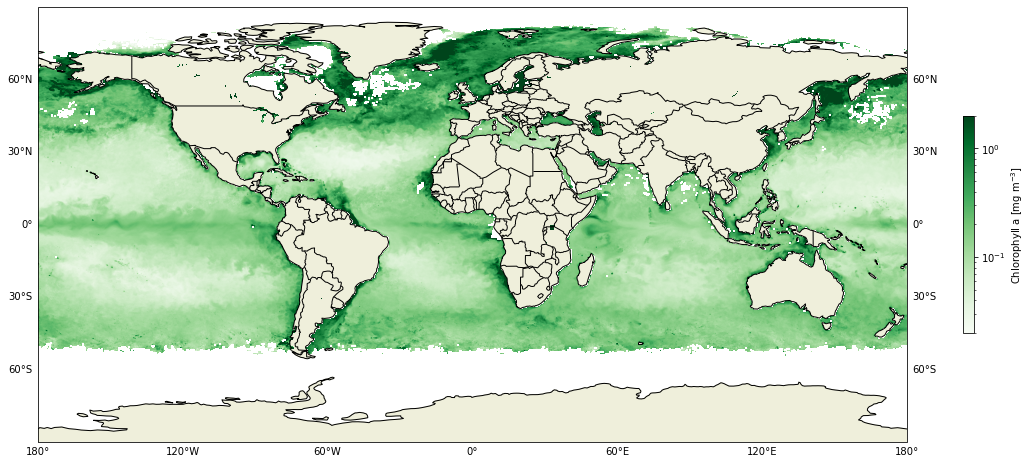

In [ ]:
cmap=plt.get_cmap('Greens')

plt.figure(figsize=(20,8))
ax = plt.axes(projection=ccrs.PlateCarree())

gl=ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.xlines=None
gl.ylines=None

im=plt.imshow(chl, 
           cmap=cmap,
           norm=LogNorm(vmin=0.02, vmax=2),
           extent=[-180,180,90,-90])
plt.colorbar(im,shrink=0.5, label='Chlorophyll a [mg m$^{-3}$]')
ax.invert_yaxis()

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.BORDERS);

## In-class exercise \#1: querry the chlorophyll time series averaged over a region in North Atlantic

Instructions:
 - Follow the "Query" Example \#2 provided by CMAP under Data Retrieval (API) section of the documentation: https://github.com/simonscmap/pycmap#1-data-retrieval-api 
 - Use SQL language for denoting averaged quantities, like AVG(lat) and AVG(chl) 
 - Specify the boundaries of the box: lat BETWEEN 40 AND 50 AND lon BETWEEN -40 AND -20
 - Use SQL language to group and order by time as: GROUP BY [time] and ORDER BY [time] 
 - change the time column to be a proper datetime variable for easy manipulation and cleaner plots: pd.to_datetime(time_variable)
 - make a final plot of chlorophyl concentration averaged within the North Atlantic box.
 - does the chlorophyl concentration vary smoothly or spiky? 


In [48]:
#Solution
modis_NA=api.query(
         '''
         SELECT [time], AVG(lat) AS lat, AVG(lon) AS lon, AVG(chl) AS chl FROM tblCHL_REP 
         WHERE 
         [time] BETWEEN '2010-06-01' AND '2022-10-01' AND 
         lat BETWEEN 40 AND 50 AND 
         lon BETWEEN -40 AND -20
         GROUP BY [time] 
         ORDER BY [time] 
         '''
         ) 
modis_NA.time=pd.to_datetime(modis_NA.time)

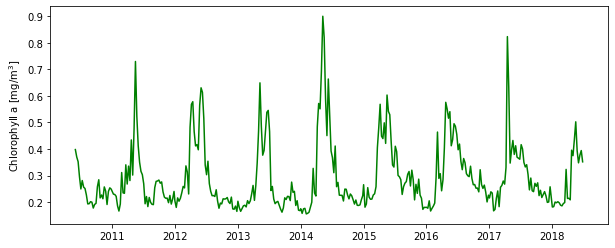

In [64]:
plt.figure(figsize=(10,4))
plt.plot(modis_NA.time, modis_NA.chl,'g');
plt.ylabel('Chlorophyll a [mg/m$^3$]');

## Chlorophyll distribution with depth: light attenuation vs lack of nutrients

Recall that photosynthesis requires light and nutrients for primary production to occur. At the same time, the light is most available at the surface and it decays exponentially with depth. However, during the Chemical Oceanography tutorial we figured out that there is a lack of nutrients at the surface of the ocean. So where in the water column does photosynesis predominantly occur? 

<img src="Attenuation-of-light-underwater.png" width=400/>

### Let's address this question using the already familiar HOT dataset

In [50]:
# read in hawaii ocean time series (HOT) data (1998-2019)
## https://simonscmap.com/catalog/datasets/HOT_PP
HOT = api.get_dataset('tblHOT_PP')
print(f'HOT columns only: {HOT.columns.values.tolist()}\n')

HOT columns only: ['time', 'lat', 'lon', 'depth', 'cruise_name', 'chl_hot', 'phaeopigments_hot', 'itype', 'light_12_hot', 'dark_12_hot', 'salinity_hot', 'prochlorococcus_hot', 'heterotrophic_bacteria_hot', 'synechococcus_hot', 'eukaryotes_hot']



In [51]:
#The HOT data comes at different depths, so let's make those into categories
HOT['depth_cat'] = HOT['depth']//20*20;  #using the floor division operator // to create depth bins separated by 20m.
HOT[HOT['depth_cat']==80]=np.nan;        #excluding categories where there is a small number of observations

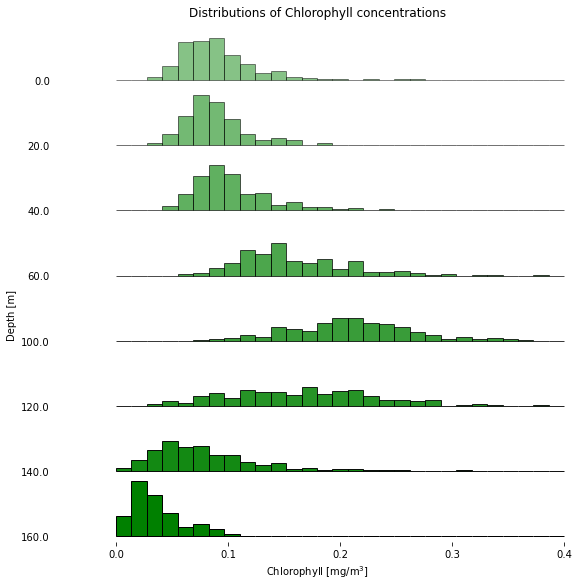

In [52]:
fig, axes = joyplot(HOT, by = 'depth_cat', column = 'chl_hot', 
                    color='Green', fade = True, 
                    title='Distributions of Chlorophyll concentrations',
                    x_range=[-0.05,0.41],
                    hist=True, bins=np.linspace(0, 0.4,30), overlap=0,
                    figsize=(8,8))
axes[-1].set_xlabel('Chlorophyll [mg/m$^3$]') 
axes[4].set_ylabel('Depth [m]') 
plt.savefig('chl_depth.pdf')
plt.show()

#### maybe an alternate dataset we could use to show light attenuation could be the AMT

In [55]:
amt = api.get_dataset('tblAMT13_Chisholm')

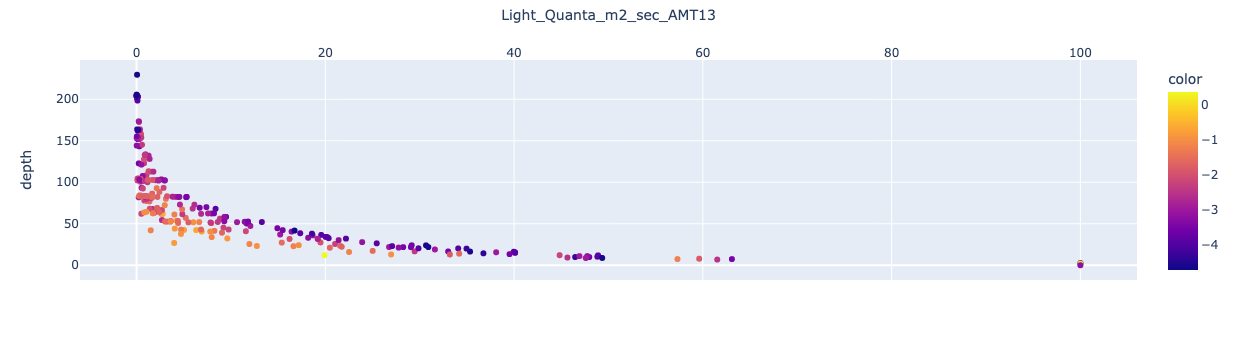

In [56]:
# show light attenuation with chlorophyll
fig = px.scatter(amt, x='Light_Quanta_m2_sec_AMT13', y='depth', color=np.log(amt['chlA_AMT13']))
# show depth profile with light
fig.update_layout(
    
    xaxis={'side': 'top'}, 
    yaxis={'side': 'left'}  
)

## What micro-organisms are there in the ocean?

<img src="organisms.png"/>

Armbrust, E. V., & Palumbi, S. R. (2015). Uncovering hidden worlds of ocean biodiversity. Science, 348(6237), 865-867. https://doi.org/10.1126/science.aaa7378

### Seaflow and IFCB datasets for community shifts

In [57]:
# read in seaflow dataset (surface level- 5m- continuous samples across 50 cruises)
seaflow = api.get_dataset('tblSeaFlow')
print(f'seaflow columns only: {seaflow.columns.values.tolist()}\n')
# can also get with ancilliary data
#seaflow_all = api.get_dataset_with_ancillary("tblSeaFlow")
#print(f'seaflow with ancilliary: {seaflow_all.columns.values.tolist()}')

seaflow columns only: ['time', 'lat', 'lon', 'depth', 'cruise', 'abundance_prochloro', 'abundance_synecho', 'abundance_picoeuk', 'abundance_croco', 'diam_prochloro', 'diam_synecho', 'diam_picoeuk', 'diam_croco', 'Qc_prochloro', 'Qc_synecho', 'Qc_picoeuk', 'Qc_croco', 'biomass_prochloro', 'biomass_synecho', 'biomass_picoeuk', 'biomass_croco']



In [58]:
seaflow.cruise.unique()

array(['TN248', 'Tokyo_3', 'CN11ID', 'TN271', 'TN280', 'CN12ID', 'TN292',
       'KN210-04', 'CN13ID', 'KM1427', 'KM1502', 'KM1508', 'KM1510',
       'KM1512', 'KM1513', 'KOK1512', 'KOK1515', 'KM1518', 'KM1601',
       'KM1602', 'KM1603', 'KOK1604', 'KOK1606', 'KOK1607', 'KOK1608',
       'KOK1609', 'MGL1704', 'KM1708', 'KM1709', 'KM1712', 'KM1713',
       'KM1717', 'KM1802', 'FK180310-1', 'FK180310-2', 'KOK1801',
       'KOK1803', 'KOK1804', 'KOK1806', 'KOK1807', 'KM1821', 'KM1823',
       'KM1901', 'KM1903', 'KM1906', 'KM1909', 'KM1912', 'KM1915',
       'KM1917', 'SR1917'], dtype=object)

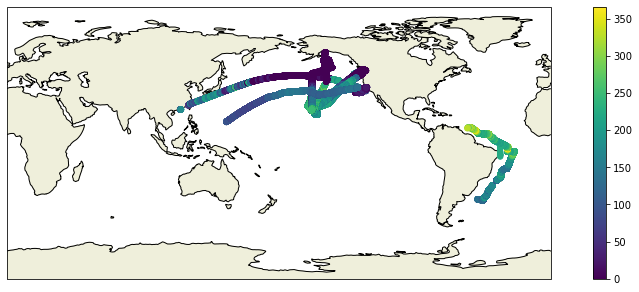

In [59]:
##Example plot of prochlorococcus biomass distribution for seaflow
#fig = px.scatter_geo(seaflow, lat='lat',lon='lon',color='abundance_prochloro')
#fig.show()

ind=seaflow['cruise']=='KOK1606'

plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180)); #this specifies which projection to use
ax.set_global();
ax.add_feature(cfeature.COASTLINE);
ax.add_feature(cfeature.LAND);
#ax.add_feature(cfeature.BORDERS);
im=ax.scatter(seaflow['lon'],seaflow['lat'],30,c=seaflow['abundance_prochloro'],transform=ccrs.PlateCarree());
plt.colorbar(im);


### Seaflow Size classes: <5µm

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



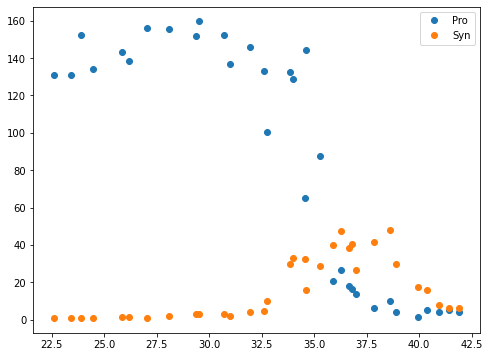

In [60]:
# pull out seaflow data from G2 to compare with IFCB abundances
seaflow_g2 = seaflow[seaflow['cruise']=='MGL1704']
# take a daily average to avoid diel cycle oscillations
seaflow_g2['time'] = pd.DatetimeIndex(seaflow_g2['time'])
seaflow_daily = seaflow_g2.groupby([pd.Grouper(key="time", freq='12H'), 
                            pd.Grouper(key="cruise")]).mean().reset_index()
plt.figure(figsize=(8,6))
# plot Pro- abundance in cells/µL
plt.plot(seaflow_daily['lat'], seaflow_daily['abundance_prochloro'], marker='o', linestyle='', label='Pro')
# plot Syn
plt.plot(seaflow_daily['lat'], seaflow_daily['abundance_synecho'], marker='o', linestyle='', label='Syn')
# label approximately where gyre starts/stops
plt.legend()

### IFCB size classes: <10 to 150 μm

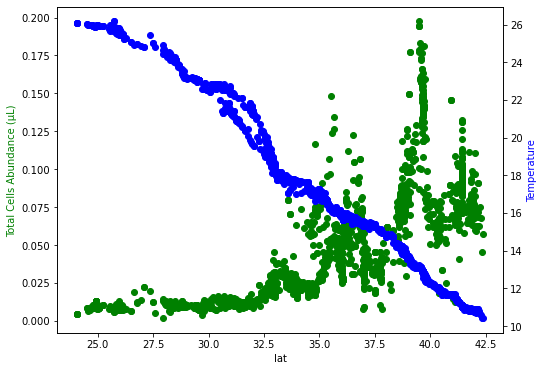

In [61]:
# Read in G2 IFCB data- all at surface 5m (same as Seaflow)
ifcb_g2 = api.get_dataset('tblMGL1704_Gradients2_IFCB_Abundance')
# convert data from wide to long for better analysis
ifcb_long = pd.melt(ifcb_g2,
                       ['time','lat','lon','depth','Sample','Total_Cells', 'Temperature','Salinity'],
                       var_name='species',
                       value_name='abundance').dropna()
# adjust abundance to be in same scale as seaflow (cells/L -> cells/µL)
ifcb_long['abundance'] = ifcb_long['abundance']/1e+6
ifcb_long['Total_Cells'] = ifcb_long['Total_Cells']/1e+6
# group by same time scale as pro/syn from seaflow data
ifcb_long['time'] = pd.DatetimeIndex(ifcb_long['time'])
ifcb_12H = ifcb_long.groupby([pd.Grouper(key="time", freq='12H'), 
                            pd.Grouper(key="species")]).mean().reset_index()

# plot total cell abundance and temp together
fig, ax1 = plt.subplots(figsize=(8,6))

ax2 = ax1.twinx()
# plot cell abundance on one side
ax1.plot(ifcb_12H['lat'], ifcb_12H['Total_Cells'], marker='o', linestyle='', color='g')
# plot temperature on other side
ax2.plot(ifcb_12H['lat'], ifcb_12H['Temperature'], marker='o', linestyle='', color='b')

ax1.set_xlabel('lat')
ax1.set_ylabel('Total Cells Abundance (µL)', color='g')
ax2.set_ylabel('Temperature', color='b')

plt.show()
# total abundance of cells much lower than seaflow abundances, especially Pro- which makes sense

In [62]:
## categorize ifcb species into higher level groups
# convert R code to Python :(

In [63]:
species_list

NameError: name 'species_list' is not defined

In [65]:
# everything on the genus level
record_list = []
species_list = pd.unique(ifcb_12H['species'])
for species in species_list:
    # get aphia records
    records = pyworms.aphiaRecordsByName(species, marine_only=False)
    # loop through records
    for record in records:
        # check if genus level and status is up to date
        print(species)
        if (record['status']=='accepted') & (record['rank']=='Genus'):
            # get classifications- haptophytes
            if record['phylum']=='Hatophyta':
                cat = {record['scientificname']:'Hatophyta'}
            # diatoms
            elif record['phylum']=='Ochrophyta':
                cat = {record['scientificname']:'Bacillariophyceae'}
            # dinoflagellate phylum
            elif record['phylum'] == 'Myzozoa':
                cat = {record['scientificname']:'Dinoflagellata'}
            # other- add N-fixers later?
            else:
                cat = {record['scientificname']:'Other'}
            # append category to record list
            record_list.append(cat)
        break

NameError: name 'pyworms' is not defined

In [ ]:
pyworms.aphiaRecordsByName('Discophaera', marine_only=False)

In [ ]:
species_list

### Data from Flombaum et al 2013

In [ ]:
# flowcytometry data that went into Flombaum et al
fl_2013 = api.get_dataset('tblFlombaum')

In [ ]:
# lets look at prochlorococcus abundance above 50 m
fl_surface = fl_2013[fl_2013['depth']>= 50]
pro_min, pro_max = np.min(fl_surface['prochlorococcus_abundance_flombaum']), np.max(fl_surface['prochlorococcus_abundance_flombaum'])
px.scatter_geo(fl_surface, lat='lat',lon='lon',color='prochlorococcus_abundance_flombaum', 
               animation_frame='year', range_color=[pro_min, pro_max])